In [1]:
# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# pandas for dataframes
import pandas as pd

# numpy for math
import numpy as np

# train-test split convenience function
from sklearn.model_selection import train_test_split

# pyplot plotting library
import matplotlib.pyplot as plt

# utility functions
from utils.processing import numpy_sequence_target

In [152]:
# use gpu instead of cpu if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Create dataset

### Linear Model

#### Independent and Dependent Variable

In [1]:
FROM = 0
TO = 20
NUM = 1000

x_axis = np.linspace(FROM, TO, num= NUM)

# intercept
INTER = 5.0
# slope
SLP = 5.0
# amplitude
AMP = 10.0
# seasonality
SEAS = np.sin(x_axis)

# intercept + trend + seasonality
y_axis = INTER + ( SLP * x_axis ) + ( AMP * SEAS )

NameError: name 'np' is not defined

In [ ]:
def minmax_normal(x : np.array):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [2]:
def minmax_restore(values_to_restore : np.array, input_minmax : np.array):
    return values_to_restore * (np.max(input_minmax) - np.min(input_minmax)) + np.min(input_minmax)

NameError: name 'np' is not defined

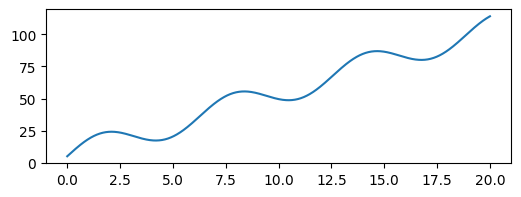

In [227]:
plt.figure(figsize= (6,2))
plt.plot(x_axis, y_axis)
plt.show()

In [228]:
y_target = minmax_normal(y_axis)

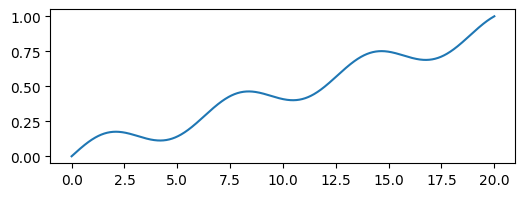

In [229]:
plt.figure(figsize= (6,2))
plt.plot(x_axis, y_target)
plt.show()

In [230]:
y_target_restored = minmax_restore(y_target, y_axis)

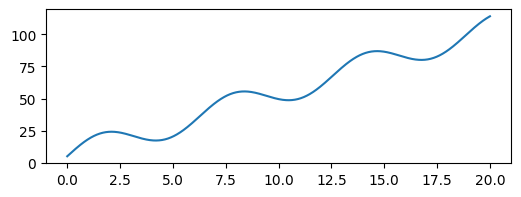

In [232]:
plt.figure(figsize= (6,2))
plt.plot(x_axis, y_target_restored)
plt.show()

### Sequence-target Dataset

In [157]:
# create set of sequences and targets from time series where sequence_length is the number of past time steps in a sequence
SEQUENCE_LENGTH = 5
sequences, targets = numpy_sequence_target(y_axis, sequence_length= SEQUENCE_LENGTH)

In [158]:
print(sequences[0], targets[0])

[[0.        ]
 [0.00275166]
 [0.00550258]
 [0.00825203]
 [0.01099928]] 0.013743591923829089


In [159]:
# create test-train data split

In [160]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size= 0.1, shuffle= True)
print('Train split:', X_train.shape, y_train.shape)
print('Test split:', X_test.shape, y_test.shape)

Train split: (895, 5, 1) (895,)
Test split: (100, 5, 1) (100,)


In [161]:
# change numpy array to tensors
X_train, X_test, y_train, y_test = list(map(torch.as_tensor, (X_train, X_test, y_train, y_test)))

# change the tensors to float32
X_train, X_test, y_train, y_test = list(map(torch.Tensor.to, (X_train, X_test, y_train, y_test), np.repeat(torch.float32, 4)))

# put the tensors on the cuda device
X_train, X_test, y_train, y_test = list(map(torch.Tensor.to, (X_train, X_test, y_train, y_test), np.repeat(device, 4)))

# add axis to y sets to match output from model
y_train, y_test = list(map(torch.unsqueeze, (y_train, y_test), (-1,-1)))

In [162]:
print('Train split:', X_train.shape, y_train.shape, X_train.dtype, X_train.device)
print('Test split:', X_test.shape, y_test.shape, X_test.dtype, X_test.device)

Train split: torch.Size([895, 5, 1]) torch.Size([895, 1]) torch.float32 cuda:0
Test split: torch.Size([100, 5, 1]) torch.Size([100, 1]) torch.float32 cuda:0


In [163]:
# prepare Dataset
dataset = TensorDataset(X_train, y_train)

# prepare Dataloader
dataloader= DataLoader(dataset, batch_size= 10, shuffle= True)

print(dataloader.__dict__)

{'dataset': <torch.utils.data.dataset.TensorDataset object at 0x000002904E0D1090>, 'num_workers': 0, 'prefetch_factor': None, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, 'in_order': True, '_dataset_kind': 0, 'batch_size': 10, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x000002904E0D1450>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x000002904E0D1590>, 'generator': None, 'collate_fn': <function default_collate at 0x0000029077726700>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


## Instantiate Model

### Observe the changes from the input to output

In [164]:
# Model
IN = 1
HID = 1
LAY = 1

# Input
SEQ = 1
BAT = 1
FEAT = IN

test_lstm = nn.LSTM(input_size= IN, hidden_size= HID, num_layers= LAY)
input_test = torch.rand(SEQ, BAT, FEAT)
with torch.inference_mode():
    output, (hn, cn) = test_lstm(input_test)
print('>> OUTPUT', f'--- Shape: (SEQ, BAT, HID) {list(output.shape)} ---')
print(output.numpy())
print('>> HIDDEN', f'--- Shape: (LAY, BAT, HID) {list(hn.shape)} ---')
print(hn.numpy())

>> OUTPUT --- Shape: (SEQ, BAT, HID) [1, 1, 1] ---
[[[-0.03205252]]]
>> HIDDEN --- Shape: (LAY, BAT, HID) [1, 1, 1] ---
[[[-0.03205252]]]


### Define Model

In [165]:
class TestLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, number_layers, **kwargs):
        super().__init__()

        # hyperparameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_layers = number_layers

        # 1. Layer
        self.lstm_layer = nn.LSTM(self.input_size, self.hidden_size, self.number_layers, **kwargs)

        # 2. Layer (depends on hidden_size)
        # use linear layer to produce one out feature        
        if self.hidden_size > 1:
            self.linear_hidden = nn.Linear(in_features= self.hidden_size, out_features=1, bias= False)

        # 3. Layer
        # use linear layer as a final dense layer to ensure estimations that lay outside of [-1, 0]
        self.linear_dense = nn.Linear(1,1)
        

    def forward(self, x):
        output, (hn, cn) = self.lstm_layer(x)
        final_hn = hn[-1] # final layer of hn contains final hidden state

        # turn dim of (batch_size, hidden_size) -> (batch_size, 1)
        if self.hidden_size > 1:
            final_hn = self.linear_hidden(final_hn) 
        
        return self.linear_dense(final_hn)

## Train Model

In [166]:
INPUT_SIZE = 1
HIDDEN_SIZE = 1
NUMBER_LAYERS = 1

test_lstm = TestLSTM(INPUT_SIZE, HIDDEN_SIZE, NUMBER_LAYERS)

test_lstm.state_dict()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params= test_lstm.parameters(), lr= 0.01)

EPOCHS = 70
test_lstm.to(device)
test_lstm.train()

TestLSTM(
  (lstm_layer): LSTM(1, 1)
  (linear_dense): Linear(in_features=1, out_features=1, bias=True)
)

In [167]:
for epoch in range(EPOCHS):

    # accumulated from all batches in an epoch
    loss = 0
    
    for X, y in dataloader: # X from data loader is (batch_size, sequence_length, features)
        # forward pass 
        output = test_lstm(X.permute(1, 0, 2)) # (batch_size, sequence_length, features) -> (sequence_length, batch_size, features)
        # loss function
        loss += loss_fn(output, y)
        
    # zero out gradients
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update parameters
    optimizer.step()

    if epoch % 10 == 0:
        with torch.inference_mode():
            output = test_lstm(X_test.permute(1, 0, 2))
            test_loss = loss_fn(output, y_test)
        
        print(f'Epoch: {(epoch+1):5} | Loss: {loss:4.2f} | Test Loss: {test_loss:4.5f}')

Epoch:     1 | Loss: 6.76 | Test Loss: 0.06737
Epoch:    11 | Loss: 5.68 | Test Loss: 0.06176
Epoch:    21 | Loss: 4.49 | Test Loss: 0.04572
Epoch:    31 | Loss: 2.46 | Test Loss: 0.02284
Epoch:    41 | Loss: 0.24 | Test Loss: 0.00128
Epoch:    51 | Loss: 0.36 | Test Loss: 0.00349
Epoch:    61 | Loss: 0.08 | Test Loss: 0.00075


## Plot forecast

In [417]:
# forcast backwards and forwards
PAST = -100
FUTURE = 100
# despite only learning from 100 observations, using 1000 for forecasting still produces accurate estimations
NUM_TEST = 20000 

x_test = np.linspace(PAST, FUTURE, NUM_TEST)

SEAS = np.sin(x_test)

y_test = INTER + ( x_test * SLP ) + ( SEAS * AMP )
y_test_minmax = minmax_normal(y_test)

In [418]:
sequences_test, _ = numpy_sequence_target(y_test_minmax, sequence_length= SEQUENCE_LENGTH)

In [419]:
print(sequences_test[0], sequences_test.shape)

[[0.        ]
 [0.00013738]
 [0.00027423]
 [0.00041056]
 [0.00054635]] (19995, 5, 1)


In [420]:
sequences_input = torch.tensor(sequences_test, dtype= torch.float32, device= device).permute(1, 0, 2)

In [421]:
sequences_input.shape

torch.Size([5, 19995, 1])

In [422]:
with torch.inference_mode():
    forecast = test_lstm(sequences_input)

In [423]:
# cpu() disconnects the gpu in order to convert to numpy array
forecast = forecast.cpu().numpy().flatten()

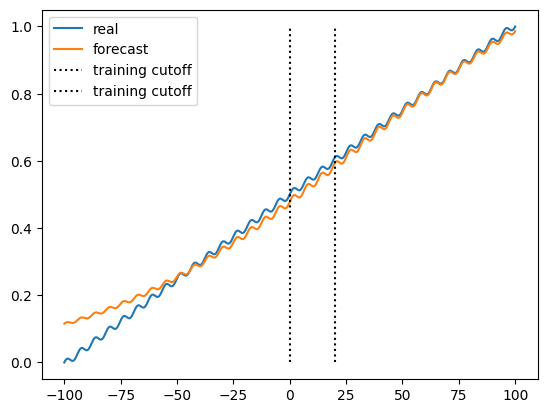

In [424]:
plt.plot(x_test, y_test_minmax, label= 'real')
plt.plot(x_test[5:], forecast, label= 'forecast')
plt.vlines(0, 0, 1, color= 'black', linestyle= 'dotted', label= 'training cutoff')
plt.vlines(20, 0, 1, color= 'black', linestyle= 'dotted', label= 'training cutoff')
plt.legend(loc= 'upper left')
plt.show()

In [425]:
print(forecast.shape)
print(y_test.shape)

(19995,)
(20000,)


In [426]:
y_test_rest = minmax_restore(y_test_minmax, y_test)
forecast_rest = minmax_restore(forecast, y_test)

In [427]:
forecast_rest.shape

(19995,)

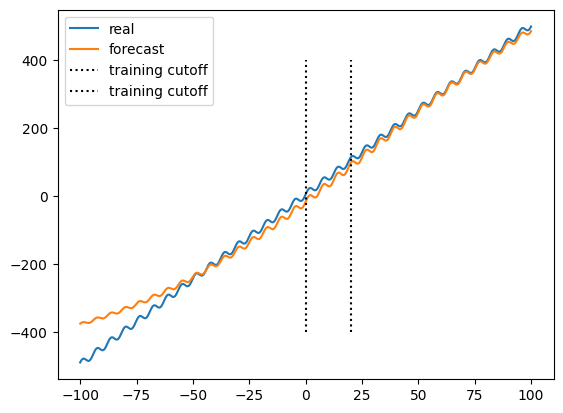

In [428]:
plt.plot(x_test, y_test_rest, label= 'real')
plt.plot(x_test[5:], forecast_rest, label= 'forecast')
plt.vlines(0, -400, 400, color= 'black', linestyle= 'dotted', label= 'training cutoff')
plt.vlines(20, -400, 400, color= 'black', linestyle= 'dotted', label= 'training cutoff')
plt.legend(loc= 'upper left')
plt.show()